# A Prototype for Compositional Probabilistic Infectious Disease

Modelling

Samuel P. C. Brand
[](https://orcid.org/0000-0003-0645-5367)
(Center for Forecasting and Outbreak Analysis; Centers for Disease
Control, United States of America)  
Samuel Abbott
[](https://orcid.org/0000-0001-8057-8037)
(Centre for Mathematical Modelling of Infectious Diseases, London School
of Hygiene & Tropical Medicine, United Kingdom)  
2025-10-08

Recent outbreaks of Ebola, COVID-19 and mpox have demonstrated the value
of modelling for synthesising data for rapid evidence to inform decision
making. Effective models require integration of expert domain knowledge
from clinical medicine, environmental science, behavioural research, and
public health to accurately capture transmission processes, yet current
modelling approaches create barriers to this integration. Methods used
to synthesise available data broadly fall into pipeline approaches that
chain separate models together, or joint models that are often
monolithic and difficult to adapt. These barriers have prevented
advances across multiple settings where models could have provided
actionable insights. Composable models where components can be reused
across different contexts and combined in various configurations whilst
maintaining statistical rigour could address these limitations. Beyond
enabling modellers to build models more efficiently, standardised
component interfaces provide structured environments for large language
models to compose and validate epidemiological models. In this work, we
start by outlining the key requirements for a composable infectious
disease modelling framework and then present a prototype that addresses
these requirements through composable epidemiological components built
on Julia’s type system and `Turing.jl`. Our approach enables “LEGO-like”
model construction where complex models emerge from composing simpler,
reusable components. Through three case studies using the prototype, we
show how components can be reused across different models whilst
maintaining statistical rigour. The first replicates a COVID-19 analysis
for South Korea using renewal processes with time-varying reproduction
numbers. The second extends these components with reporting delays and
day-of-week effects for real-time nowcasting applications. The third
integrates ODE solvers for compartmental disease transmission models
applied to influenza outbreak data. Across all case studies, the same
core components combine differently to address distinct epidemiological
questions. We explore other potential options and compare them to our
proposed approach. The prototype demonstrates promise but future work is
needed to solve remaining composability challenges, expand the component
library, integrate bridges to existing epidemiological software
ecosystems, and explore opportunities for large language model assisted
model construction in resource-constrained settings.

<sup>1</sup> Center for Forecasting and Outbreak Analysis; Centers for
Disease Control, United States of America  
<sup>2</sup> Centre for Mathematical Modelling of Infectious Diseases,
London School of Hygiene & Tropical Medicine, United Kingdom

<sup>✉</sup> Correspondence: [Samuel Abbott
\<sam.abbott@lshtm.ac.uk\>](mailto:sam.abbott@lshtm.ac.uk)

# Introduction

Recent outbreaks of Ebola, COVID-19 and mpox have demonstrated the value
of modelling for synthesising data for rapid evidence to inform decision
making \[1\]. Infectious diseases spread through complex interactions
between biology, human behaviour, economic factors, and environmental
conditions that must all be understood to control transmission
effectively. Effective models require integration of expert domain
knowledge from clinical medicine, environmental science, behavioural
research, and public health to accurately capture these multifaceted
transmission processes, yet current modelling frameworks create barriers
to this integration. Individual-level data such as viral loads,
biomarkers, genomic sequences, and clinical observations are routinely
ignored or aggregated when informing population-level models, losing
information that could improve decisions. These barriers have prevented
advances in settings where models could have provided actionable
insights such as early outbreak analysis, wastewater surveillance,
phylodynamics, clinical biomarkers, pooled testing, and large-scale
clinical datasets. The next infectious disease threat is unpredictable
and may be exacerbated by climate change \[2\], requiring adaptable
response capabilities that can rapidly incorporate diverse data sources
and domain expertise.

Methods used to synthesise available data in real time broadly fall into
two classes: either combining results from multiple, smaller models
calibrated in isolation (the pipeline approach, e.g., \[3\]), or
representing a single model tuned to the specific scenario (the joint
model approach, e.g., \[4,5\]). Both approaches have downsides. Pipeline
approaches combine results from separate models without uncertainty
propagation, leading to loss of detail and statistical rigour \[6\].
Joint approaches use single monolithic models that, whilst able to
integrate multiple processes and data streams, are too complex to enable
transfer to other settings or extension with additional model
components. To adapt or extend such models, analysts need to fully
comprehend all parts of the corresponding model and code, creating
barriers to sharing methodology and leading to inefficient
re-implementation when parts of a model could, in principle, be re-used.
Attempts to include insights from environmental scientists, economists,
or behavioural researchers typically result in models that are either
too complex to use practically or too simplified to capture valuable
expertise. This prevents effective integration of expertise across
disciplines. Transfer of methodology between outbreak events has proven
difficult, with each posing unanticipated challenges that existing tools
cannot accommodate. Whilst large language models offer potential to
assist with model construction, current monolithic approaches lack the
structured component interfaces and validation frameworks needed for
such systems to compose models reliably.

Recent developments in computational statistics and scientific computing
demonstrate the potential for composable approaches where components can
be reused across different contexts and combined in various
configurations whilst maintaining statistical rigour that could address
these limitations. Advances in `Turing.jl` have introduced submodel
interfaces that enable composable probabilistic programming, providing a
pathway for epidemiological model composition, though initial
epidemiological applications revealed interoperability challenges
\[7,8\]. Category theory provides one mathematical framework for this
composability through operadic composition in hierarchical model
construction, as applied in the AlgebraicJulia ecosystem \[9\].
Alternative approaches to compositional modelling include the SciML
ecosystem’s \[10\] symbolic-numeric framework, where
`ModelingToolkit.jl` \[11\] and `Catalyst.jl` \[12\] use acausal
equation-based modelling with automated symbolic transformations to
support mixed equation types including differential-algebraic equations,
partial differential equations, and stochastic differential equations
through unified interfaces. `HydroModels.jl` \[13\] demonstrates
compositional hydrological modelling with differentiable neural-enhanced
components, whilst `SpeedyWeather.jl` uses an interactive
domain-specific language approach for “LEGO-like” atmospheric modelling
with modular component assembly \[14\]. The key insight underlying these
approaches is the separation of structural syntax, which defines valid
compositions, from computational semantics, enabling modularity and
independence of components whilst maintaining mathematical rigour.

<a href="#fig-schematic" class="quarto-xref">Figure 1</a> demonstrates
how these compositional principles could enable component reuse across
different epidemiological applications. Three example applications
wastewater surveillance, biomarker modelling, and early outbreak
analysis each compose models from components of different types. The
schematic also highlights two examples of component reuse. The
incubation period model appears in all three applications, and the
within-host viral kinetics model is shared between biomarker modelling
and wastewater surveillance. This highlights how components developed
for one application could be incorporated into others when they share
common underlying processes.

<figure id="fig-schematic">
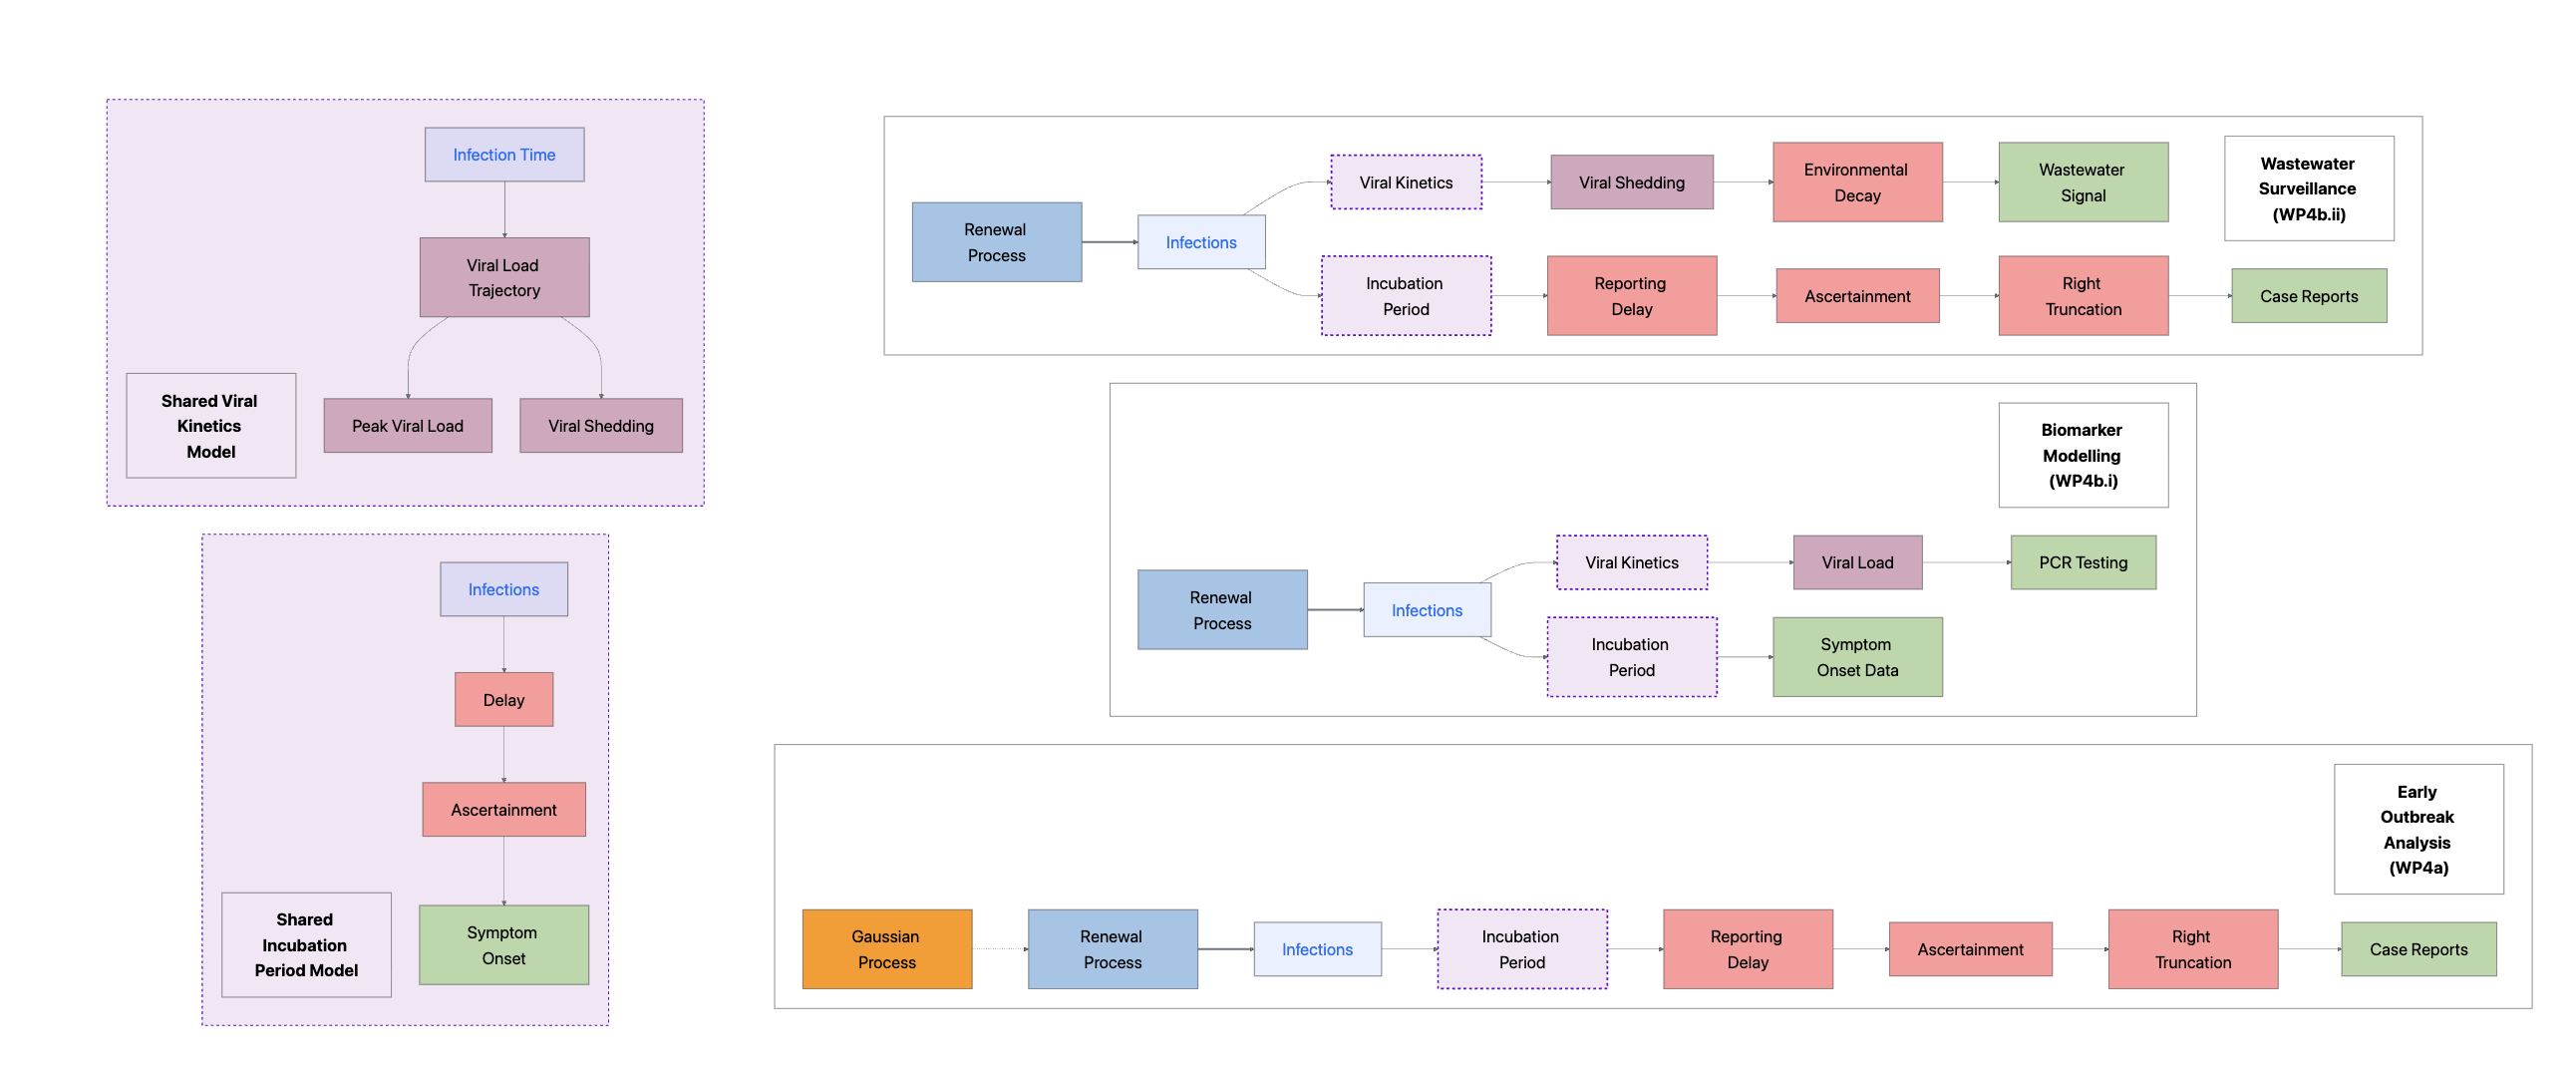
<figcaption>Figure 1: Demonstration of composability showing how three
applications share common components. Colours correspond to component
types: infection processes (blue), statistical processes (orange),
infection modifiers (yellow), epidemiological latent processes (purple),
observation modifiers (red), and observation models (green). Two shared
submodels are highlighted with purple borders and background fill: the
Incubation Period model (reused across all applications) and the
Within-host Viral Kinetics model (shared between Biomarker Modelling and
Wastewater Surveillance).</figcaption>
</figure>

This paper presents a prototype that combines the modularity of pipeline
approaches with the statistical rigour of joint models through
composable epidemiological components. Our approach enables “LEGO-like”
model decisions through standardised interfaces similar to those used in
`SpeedyWeather.jl` \[14\]. The prototype supports composability beyond
ordinary differential equations, accommodating mixed equation types and
the potential for different computational backends. We implement this as
a domain-specific language operating intended to be implemented as
optional package extensions. We demonstrate our approach using an
autoregressive model example to illustrate the proposed compositional
pattern and component swapping capabilities. Through three case studies
using the prototype, we show how components can be reused across
different models: the first is inspired by \[15\]; the second reuses
components from the first, along with new elements, inspired by \[16\];
the third is inspired by \[17\], again reusing components, alongside the
use of an ODE. Finally, we discuss alternative design approaches,
evaluate the strengths and limitations of our compositional approach,
and identify key areas for future development.

# Prototype Implementation

## Requirements for Composable Infectious Disease Modelling

Modelling infectious disease dynamics requires quantifying uncertainty
at every level because decisions must account for incomplete knowledge
about individual infection risk, transmission dynamics, and observation
processes. A clear separation between distinct model components,
infection processes, observation processes, and latent dynamics is also
key as these allows reasoning on each of these components separately.
Because diseases affect populations heterogeneously across age,
location, and risk groups, the framework needs to be able to support
arbitrary stratification schemes for all components. These stratified
models must also remain data-agnostic as this allows the model to be
generalised to different datasets, tested based on just its prior
specification, and used for forecasting. Similarly, the book work of
supporting multiple strata needs to be abstracted from the user to make
the system easier to use but at the same time they need to be able to
model relationships between strata to support partial pooling of
parameters for sparse data settings. To allow for models to be
validated, the framework must support nesting models within models and
programming over model structure itself, allowing simple components to
compose into sophisticated models while remaining individually
interrogable for debugging, validation, and mechanistic understanding.
This compositional approach requires a clear, concise modelling language
so that it can be used by a wide pool of users and so that model
specifications can be written quickly but with clarity. Supporting
modern inference methods is important so that complex models can be fit
and this necessitates gradient computation throughout via automatic
differentiation. It is also important to allow for a wide range of
inference methods so that the best approach for a given model/data
combination can be used. This means supporting abstract back-ends that
seamlessly switch between inference approaches.

We also need to have model components that encapsulate both structure
and prior distributions so that domain experts can contribute
specialised knowledge: a virologist’s understanding of within-host
dynamics, an epidemiologist’s of contact patterns, a clinician’s of
disease progression insights without reviewing the entire modelling
framework. Standardised interfaces between components are needed to
allow individual components to work together, to support handling of
multiple strata, and to allow for proper uncertainty propagation. Such
interfaces also enable large language models to serve as model
construction agents, composing models from component libraries whilst
validation methods ensure statistical rigour \[18\]. As there are a
range of different potential ways to express infectious disease models
including ordinary differential equations, agent-based models, network
models, stochastic processes, and discrete time models these all need to
be supported both independently and in combination. Importantly, the
design must enable incremental adoption without requiring complete
rebuilds of existing models, and components should remain functional as
standalone tools outside the compositional framework to maximise their
utility and adoption. Finally, we need a framework that can be composed
with out of domain approaches and expertise, such as neural networks,
Gaussian processes, and other machine learning approaches.

## Our approach

Meeting these requirements requires programming with probabilities, for
which probabilistic programming languages are designed. We also need a
probabilistic programming language that supports automatic
differentiation for modern inference, the ability to program over model
structure itself to enable model nesting and composition, and access to
as wide an ecosystem as possible to avoid lock-in and enable integration
with existing scientific computing tools. As far as we are aware, only
probabilistic programming languages built in Julia \[19\] provide the
metaprogramming capabilities needed to create domain-specific
abstractions that can handle arbitrary stratification, standardised
interfaces between components, and programming over the model structure.
Among Julia’s options, `Turing.jl` \[8\] best meets our requirements
with mature submodel support for nesting models within models, extensive
inference algorithm choices, and it’s implementation as a light
abstraction layer on top of the wider Julia ecosystem. Additional
benefits of Julia include eliminating the two-language problem,
leveraging multiple dispatch for clean component composition, and
accessing the mature SciML ecosystem \[10\] for differential equations
and other scientific computing tools.

Our approach uses a two-layer architecture with high-level
domain-specific language (DSL) for epidemiological modelling and a
low-level implementation using `Turing.jl` (though importantly we are
not locked in to this choice as the DSL is agnostic of the backed used).
This separation enables incremental adoption without rebuilding existing
models to use our DSL, with all components remaining functional as
standalone tools outside the compositional framework. The
domain-specific language layer provides clear, concise model
specification using epidemiological concepts, enabling domain experts to
contribute components encapsulating their specialised knowledge without
understanding the full framework. The backend layer aims to handle the
automated bookkeeping of stratification, interface validation, and
uncertainty propagation whilst supporting multiple inference approaches
and auto differentiation options by leveraging the `Turing.jl` and wider
Julia ecosystems.

## Domain-Specific Language Structure

Our prototype domain-specific language builds on Julia’s type system to
enable composable epidemiological modelling through two key design
patterns. First, abstract types define interfaces that implementations
must follow, analogous to contracts specifying what operations a model
component must support rather than how it implements them. All model
components inherit from a parent `AbstractModel` type, establishing a
common foundation whilst allowing specialised behaviour through
subtypes. Second, structures contain other structures as fields (a
struct-in-struct pattern), allowing complex models to be built by
nesting simpler components. This pattern enables models to be assembled
like building blocks whilst maintaining clear boundaries between
different epidemiological processes.

We organise model components into three abstract type hierarchies, each
of which inherits from `AbstractModel`, corresponding to distinct
epidemiological processes. `AbstractEpiModel` represents infection
generation processes such as renewal models or ordinary differential
equation transmission dynamics. `AbstractLatentModel` captures
time-varying parameters and unobserved processes such as changing
reproduction numbers or reporting rates, implemented through structures
like autoregressive processes, random walks, or moving averages.
`AbstractObservationModel` links latent states to observed data by
encoding measurement processes such as reporting delays, aggregation
over time periods, and observation error distributions. These structures
are data-agnostic, specifying what to do when they encounter data rather
than containing data themselves, making model definitions reusable
across different datasets and scenarios. Each hierarchy supports
multiple concrete implementations that can be swapped to compare
modelling assumptions whilst keeping other components fixed.

Models can compose across these hierarchies rather than being restricted
to combining components within a single type. For example, an
observation model can contain a latent process as a field to represent
time-varying ascertainment, or wrap another observation model to add
reporting delays. This cross-hierarchy composition extends the building
block analogy to include more complex models. For instance, we can
construct a delay convolution observation model, `LatentDelay`, using an
underlying observation model and a delay distribution model.

The `EpiProblem` structure is a top-level container assembling these
components into a complete epidemiological model. It holds an infection
process (`epi_model`), a latent process (`latent_model`), an observation
process (`observation_model`), and a time span for inference or
simulation. Structures can be modified in place using tools like
`Accessors.jl`, enabling both model iteration and patterns such as
partially pooled models that update low-level priors based on grouping
structures. The abstract type system enables shared methods across all
model components, such as print methods (shown below) for displaying
model specifications or functions for visualising model directed acyclic
graphs. This approach also allows for the creation of mappings between
submodels such as one to one, one to many, and many to many mappings so
that, for example, a single infection process can be linked to multiple
observations models by specifying a mapping model.

To demonstrate the structure and use of `AbstractLatentModels`, we start
with an autoregressive order two (AR(2)) process, which mathematically
is:

$$Z_t = \rho_1 Z_{t-1} + \rho_2 Z_{t-2} + \epsilon_t, \quad \epsilon_t \sim \text{Normal}(0, \sigma)$$

In our prototype DSL, this is defined using the `AR` struct. We use
priors based on \[20\] which we will reuse in
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>. Prior
distributions are specified using `Distributions.jl` \[21\], the
standard probability distributions package in the Julia ecosystem, which
provides a unified interface for probability distributions that is
interoperable with both our framework and `Turing.jl`.

In [1]:
using EpiAware, Distributions
ar2 = AR(;
    damp_priors=[truncated(Normal(0.4, 0.2), 0, 1),
        truncated(Normal(0.1, 0.05), 0, 1)],
    init_priors=[Normal(0, 0.2), Normal(0, 0.2)],
    ϵ_t=HierarchicalNormal(std_prior=HalfNormal(0.1))
)

This constructor has created the following struct definition.

In [1]:
ar2

AR(damp_prior = Product(Truncated(0.4, 0.2, 0.0, 1.0)),
   init_prior = TuringScalMvNormal([0.0, 0.0], 0.2),
   p = 2,
   ϵ_t = HierarchicalNormal(mean = 0.0,
                            std_prior = HalfNormal(0.1),
                            add_mean = false))

Another common latent model is the moving average model

$$Z_t = \epsilon_t + \theta \epsilon_{t-1}, \quad \epsilon_t \sim \text{Normal}(0, \sigma)$$

The `MA` struct defines this in the same way that the `AR` did for the
AR process.

In [1]:
ma1 = MA(;
    θ_priors=[truncated(Normal(0.0, 0.2), -1, 1)],
    ϵ_t=HierarchicalNormal(std_prior=HalfNormal(0.1))
)

A popular combination of these models is the autoregressive moving
average (ARMA) model that can have different orders for both the AR and
MA components. An ARMA(2,1) can be defined as:

$$Z_t = \rho_1 Z_{t-1} + \rho_2 Z_{t-2} + \epsilon_t + \theta \epsilon_{t-1}$$

In our DSL this can be represented as a composition of the AR and MA
structs by updating the AR error term:

In [1]:
using Accessors
arma21 = @set ar2.ϵ_t = ma1

The result of this step has been to update the `ar2` struct so that the
definition of the moving average model is nested inside it.

In [1]:
arma21

AR(damp_prior = Product(Truncated(0.4, 0.2, 0.0, 1.0)),
   init_prior = TuringScalMvNormal([0.0, 0.0], 0.2),
   p = 2,
   ϵ_t = MA(θ = Product(Truncated(0.0, 0.2, -1.0, 1.0)),
            q = 1,
            ϵ_t = HierarchicalNormal(mean = 0.0,
                                     std_prior = HalfNormal(0.1),
                                     add_mean = false)))

Similarly, autoregressive integrated moving average (ARIMA) models
extend ARMA by adding differencing operations that transform the series

$$\Delta Z_t = Z_{t} - Z_{t-1}$$

So that the ARIMA(2,1,1) model is defined as an ARMA(2,1) model for the
first order differences:

$$\Delta Z_t = \rho_1 \Delta Z_{t-1} + \rho_2 \Delta Z_{t-2} + \epsilon_t + \theta \epsilon_{t-1}$$

We compose the ARMA model with a differencing operation using the
`DiffLatentModel` wrapper:

In [1]:
arima211 = DiffLatentModel(arma21, Normal(0, 0.2); d=1)

Alternatively, EpiAware provides an `arima()` constructor function that
simplifies this specification.

Other latent models extend modelling options through combining models
additively, multiplicative scaling, and piecewise processes. This
approach enables representation of arbitrary latent processes through
composition.

## Backend Implementation: Turing Interface

Our DSL translates to Turing models through generate functions that
dispatch on abstract type hierarchies. Each abstract type
(`AbstractLatentModel`, `AbstractEpiModel`, `AbstractObservationModel`)
has a generate function interface that concrete model types must
implement a method to dispatch upon. When a generate function receives a
model component, Julia’s multiple dispatch automatically selects the
appropriate implementation based on the component’s type, producing
`Turing.jl` \[8\] code using the `@model` macro. Unit tests are used to
ensure concrete implementations satisfy interface requirements, enabling
all components to interoperate correctly regardless of which specific
model types are composed together. This approach means new model types
integrate seamlessly without modifying existing code, and users can swap
components to compare modelling assumptions whilst keeping other parts
of the model fixed.

The generated Turing models serve dual purposes: simulation by sampling
from prior distributions, or inference by conditioning on observed data
and applying Turing’s suite of algorithms including gradient-based
methods like the No U-Turn Sampler (NUTS) \[22\]. These are standard
Turing models with no special constraints beyond those imposed by the
`Turing.jl` framework itself, supporting all `DynamicPPL.jl` operations
such as parameter fixing, model conditioning, and posterior predictive
sampling. Generated components can be used directly as standalone models
or nested within other Turing models using the `@submodel` macro,
enabling incremental adoption where only parts of a model use the
compositional framework whilst other parts use custom `Turing.jl`.

Many computational components are backend-agnostic, containing no
probabilistic programming constructs and therefore portable to other
frameworks. For example, we use a common pattern, `accumulate_scan`,
which builds on the base accumulate function to model iterative temporal
processes through step functions. These step functions are structs built
on the `AbstractAccumulationStep` interface that implement a callable
defining the single-step update rule. Mathematical utilities such as
functions for converting between reproduction numbers and growth rates,
discretising continuous delay distributions, and reparameterising
observation error models are similarly backend-agnostic. This separation
enables a package extension pattern where standard Julia packages
provide domain-specific functionality whilst the compositional layer is
added as an optional extension, allowing users to adopt the framework
incrementally without requiring their entire workflow to commit to the
compositional approach.

Returning to our example from the DSL section, the autoregressive
process can be mapped from its high-level representation to a Turing
model using the `generate_latent` function and multiple dispatch, which
generates the following `Turing.jl`:

@model function EpiAwareBase.generate_latent(latent_model::AR, n)
    p = latent_model.p
    @assert n>p "n must be longer than order of the autoregressive process"

    ar_init ~ latent_model.init_prior
    damp_AR ~ latent_model.damp_prior
    @submodel ϵ_t = generate_latent(latent_model.ϵ_t, n - p)

    ar = accumulate_scan(ARStep(damp_AR), ar_init, ϵ_t)

    return ar
end

The key line `@submodel ε_t = generate_latent(latent_model.ε_t, n - p)`
enables composition by delegating to whatever error model was provided.
The AR dynamics are implemented through a custom accumulation step that
maintains the autoregressive state.

function (ar::ARStep)(state, ϵ)
    new_val = dot(ar.damp_AR, state) + ϵ
    new_state = vcat(state[2:end], new_val)
    return new_state
end

This step function works with `accumulate_scan` to build the AR series
by applying the autoregressive equation at each time step. The MA model
has a similar structure with its own internal step function. The
`accumulate_scan` pattern enables composable iteration steps, allowing
complex processes like renewal models with susceptible depletion to be
built by composing simple step operations. This design means we only
need to write the single-step operation without worrying about the
iteration process, making components more modular and reusable.

The full ARIMA(2,1,1) model we defined in the DSL section can then be
generated using the same approach, producing the following `Turing.jl`.

@model function EpiAwareBase.generate_latent(latent_model::DiffLatentModel, n)
    d = latent_model.d
    @assert n>d "n must be longer than d"
    latent_init ~ latent_model.init_prior

    @submodel diff_latent = generate_latent(latent_model.model, n - d)

    return _combine_diff(latent_init, diff_latent, d)
end

The DiffLatentModel’s
`@submodel diff_latent = generate_latent(latent_model.model, n - d)`
calls the ARMA model, which in turn calls its composed AR and MA
components, then applies differencing through cumulative summing. This
recursion through `@submodel` enables arbitrary composition while
maintaining separation between components.

To demonstrate fitting these submodels we first create a model that uses
our ARIMA(2,1,1) model as submodel combining it with a normal
observation error process.

In [1]:
using DynamicPPL, Turing, LinearAlgebra

@model function arima_with_obs(arima_spec, n_timesteps)
    @submodel Z_t = generate_latent(arima_spec, n_timesteps)
    σ_obs ~ truncated(Normal(0.0, 0.001), 0, Inf)
    y_obs ~ MvNormal(Z_t, σ_obs * I)
    return y_obs
end

We can then generate synthetic data with fixed parameters which we
sample from the prior distribution using the `rand`, and `fix` functions
and calling the model to simulate the observations. We first define the
model.

In [1]:
n_timesteps = 20
gen_model = arima_with_obs(arima211, n_timesteps)

Then sample from it,

In [1]:
simulated_params = rand(gen_model)

Now we have parameters we can simulated some data using the generative
model by fixing the random variables using the sampled parameters and
the `fix` function. We can then call it, like any normal function, to
get simulated observations for `y`.

In [1]:
fixed_model = fix(gen_model, simulated_params)
y_observed = fixed_model()

For inference, we condition on the generative model using simulated
observations and the `condition` function or here the equivalent `|`
notation. Now we have a model conditioned on data we can fit it using
our choice of approach supported by `Turing.jl`. Here we decide to use
the No-U-turn sampler (a popular variant of MCMC).

In [1]:
conditioned_model = gen_model | (; y_obs = y_observed)
chains = sample(conditioned_model, NUTS(), MCMCThreads(), 2000, 4)

We can then compare our posterior distributions to the true sampled
values from our ARIMA(2, 1, 1) model using `PairPlots.jl` \[23\] with
the `CairoMakie.jl` \[24\] backend for visualisation
(<a href="#fig-arima-demo" class="quarto-xref">Figure 2</a>). The
posterior distributions recover the simulated parameter values.

# Case Studies

We demonstrate how our prototype compositional modelling DSL can
recreate and extend existing epidemiological models. Each case study
shows how complex models are built by composing reusable components,
validating their behaviour through prior predictive checks, and fitting
them to real data. The examples progress from simple renewal models to
more complex observation processes that account for reporting delays and
temporal effects.

All code and data for reproducing the analyses in this paper are
available at:
<https://github.com/EpiAware/PrototypeCompositionalProbablisticInfectiousDiseaseModelling>.

## On the derivation of the renewal equation from an age-dependent branching process: an epidemic modelling perspective

In *On the derivation of the renewal equation from an age-dependent
branching process: an epidemic modelling perspective, *Mishra et al*
(2020)* \[20\] demonstrate the mathematical correspondance between
age-dependent branching processes and time-since-infection
epidemiological models, as a renewal model with time-varying
reproduction number $R_t$. Renewal models use the renewal equation to
model how new infections arise from previous infections, weighted by the
generation time distribution (or serial interval) \[25\]. This is
analogous to an autoregressive process where the autoregressive
coefficients have epidemiological meaning rather than being estimated
parameters. They show how solutions to the renewal equation, when
combined with a negative binomial observation model, define a Bayesian
hierarchical framework for inference on reported case time series data,
demonstrating this on test-confirmed cases of COVID-19 in South Korea.

### Data

*Mishra et al* used daily reported test-confirmed cases of COVID-19 in
South Korea between January to July 2020. This data is curated by the
[`covidregionaldata`](https://github.com/epiforecasts/covidregionaldata)
package, but we have saved the South Korean data locally.

In [1]:
using Chain, CSV, DataFramesMeta, Dates
datapath = "data/south_korea_data.csv"
south_korea_data = @chain datapath begin
    CSV.read(DataFrame)
    (y_t = _.cases_new, dates = _.date)
end

### Model

Our model is inspired by *Mishra et al* and uses a log-scale
time-varying reproductive number $\log R_t$ modelled as an AR(2)
process, which in turn specifies the latent infections $I_t$ as a
solution to the renewal equation conditional on the trajectory of
$\log R_t$. The latent infection process is then linked directly to
reported cases $C_t$ on matching days using a negative binomial link
distribution. The key difference from *Mishra et al* is in the
initialization. They seed the renewal equation with importations
(independent daily effects $\mu_t \sim \text{Exponential}(0.5)$), whilst
we initialize by solving for the growth rate corresponding to the
initial reproduction number and extrapolating backwards without allowing
for ongoing importations.

$$
\begin{aligned}
\rho_1, \rho_2, Z_0, Z_{-1}, I_0,  \sigma, \phi &\sim \pi(\cdot), \\
\epsilon_t & \sim \text{Normal}(0, \sigma)~~ \text{i.i.d } \forall t, \\
Z_t &= \rho_1 Z_{t-1} + \rho_2 Z_{t-2} + \epsilon_t,~~ t = 1, 2, 3, \dots\\
R_t & = \exp(Z_t), \\
r & \text{ solves } G(r) = 1 / R_1, \\
I_{t} & = I_0 e^{rt},~~ t = 0, -1, -2, -3,-n+1, \\
I_t &= R_t \sum_{s \geq 1} g_s I_{t-s}, ~~ t = 1, 2, 3, \dots, \\
y_t & \sim \text{NegBin}(I_t, \phi), ~~ t = 1, 2, 3, \dots.
\end{aligned}
$$

Where $\pi$ is a prior distribution for the hyperparmeters of the AR(2)
model, initial states $Z_0, Z_{-1}$, the autoregressive coefficients
$\rho_1,\rho_2$ and innovations standard deviation $\sigma$, along with
initial condition value for the latent infections $I_0$ and observation
overdispersion $\phi$. $g_t$ is the generation distribution probability
mass function (pmf). $r$ is the growth rate determined by the by
$R_1 = \exp(Z_1)$ using the implicit relationship \[26\].

$$
G(r) = \sum_{j \geq 1} g_j \exp(- r j) = 1 / R_1.
$$

This means that we determine the initial condition of the latent
infecteds before $t=0$, $I_{-1}, I_{-2}, \dots, I_{-n+1}$ jointly with
sampling $R_1$ where $n$ is the maximum support value of the $g_t$ pmf.

#### Latent Model

We reuse the AR(2) model `ar2` defined in
<a href="#sec-dsl" class="quarto-xref">Section 2.3</a>, which has the
appropriate priors from *Mishra et al*. Prior predictive samples
(<a href="#fig-figure3" class="quarto-xref">Figure 3</a> A) show that *a
priori* these priors assign a few percent chance of achieving very high
$R_t$ values, i.e. $R_t \sim 10-1000$ is not excluded.

#### Infection Generating Process

The renewal equation requires a discrete generation time pmf $g_t$. Our
prototype provides a constructor that converts continuous distributions
into the required discrete pmf using double interval censoring \[27\].
This is called inside the `EpiData` struct which we use to define the
expected model specific input data. *Mishra et al* used a
$\text{Gamma}(6.5, 0.62)$ serial interval distribution,

In [1]:
truth_SI = Gamma(6.5, 0.62)
model_data = EpiData(gen_distribution=truth_SI)

<a href="#fig-figure3" class="quarto-xref">Figure 3</a> D compares the
discretized generation interval with the underlying continuous
distribution. As expected the observed discrete generation interval
differs from the underlying continuous distrbution due to the double
censoring process.

As in the earlier example, we define our renewal model using a
specialised struct, `Renewal`. This requires the discretized generation
time (from `model_data`) and an initialisation prior. We use a lognormal
prior for the initial latent infections as it has a skewed right tail
allow some weight on large initial values.

In [1]:
log_I0_prior = Normal(log(1.0), 0.1)
renewal = Renewal(model_data; initialisation_prior=log_I0_prior)

This results in the following model structure.

In [1]:
renewal

Renewal(
    data =
        EpiAware.EpiInfModels.EpiData{Float64, typeof(exp)}([0.026663134095601056, 0.14059778064943784, 0.2502660305615846, 0.24789569560506844, 0.1731751163417783, 0.09635404000022223, 0.04573437575216367, 0.019313826994143808], 8, exp),
    initialisation_prior = Normal(0.0, 0.1),
    recurrent_step =
        EpiAware.EpiInfModels.ConstantRenewalStep{Float64}([0.019313826994143808, 0.04573437575216367, 0.09635404000022223, 0.1731751163417783, 0.24789569560506844, 0.2502660305615846, 0.14059778064943784, 0.026663134095601056]))

To demonstrate the infection model independently, we define a fixed
$R_t$ trajectory that decreases from 3 to 0.5 over 50 days and pass this
to the `generate_latent_infs` function which, like the `generate_latent`
function, relies on multiple dispatch to contruct the model that the
struct it is passed defines.

In [1]:
Rt = [0.5 + 2.5 / (1 + exp(t - 15)) for t in 1:50]
renewal_mdl = generate_latent_infs(renewal, log.(Rt))

The implied distribution of $I_t$ trajectories conditional on this $R_t$
trajectory can then be sampled independently of other model components
(<a href="#fig-figure3" class="quarto-xref">Figure 3</a> B). As expected
this gives us a “classical” outbreak like dynamic with infection
incidence initially increasing exponentially, the rate of growth slowing
over time, and then finally the infection incidence “turning over”.

The full infection generating process, that is the model defined in
<a href="#sec-example1" class="quarto-xref">Section 3.1</a> without the
link to case data, can be constructed by passing samples of $Z_t$ into
the renewal model sampler.

#### Observation Model

In *Mishra et al* the overdispersion parameter $\phi$ sets the
relationship between the mean and variance of the negative binomial
errors. We default to a prior on $\sqrt{1/\phi}$ (referred to as the
cluster factor) because this quantity is approximately the coefficient
of variation of the observation noise and, therefore, is easier to
reason on *a priori* beliefs. A prior for $\phi$ was not specified in
*Mishra et al*, so we use $\sqrt{1/\phi} \sim \text{HalfNormal}(0.1)$.

In [1]:
negbin = NegativeBinomialError(cluster_factor_prior=HalfNormal(0.1))

As with the latent model, we can generate a `Turing.jl` model
conditional on a fixed latent infection trajectory. Here we simulated
this to look like an outbreak with a symmetrical growth and decay phase.

In [1]:
I_t = [1000 * exp(-(t - 15)^2 / (2 * 4)) for t in 1:30]
negbin_mdl = generate_observations(negbin, missing, I_t)

Here we use a `missing` argument to indicate observed variables that are
to be sampled rather than to be used to accumulate log posterior
density. Prior predictive samples
(<a href="#fig-figure3" class="quarto-xref">Figure 3</a> C) show the
dispersion around the mean implied by our choice of prior.

### Fitting to Data

We now compose the three model components into an `EpiProblem`, which
defines the complete generative model for the time range `tspan`.

In [1]:
tspan = (45, 80)
mishra = EpiProblem(epi_model = renewal,
    latent_model = ar2,
    observation_model = negbin,
    tspan = tspan)

We create training data by subsetting the full data to match `tspan`.

In [1]:
training_data = @chain south_korea_data begin
    @set _.y_t = _.y_t[first(tspan):last(tspan)]
    @set _.dates = _.dates[first(tspan):last(tspan)]
end

As a last step before fitting the model, we generate a new `Turing.jl`
model using `generate_epiaware`, the `EpiProblem` we just defined, and
our training data.

In [1]:
using Turing
mishra_mdl = generate_epiaware(mishra, training_data)

Following the same compositional pattern as our modelling DSL, we also
support composing inference approaches using `EpiMethod`, which, for
example, can combine pre-sampling steps with sampling algorithms. We use
the No U-Turns (NUTS) sampler with batched implementation of pathfinder
variational inference \[28\] that returns the single pathfinder route
with maximum estimated evidence lower bound to estimate the intialise
the sampler.

In [1]:
using ReverseDiff
inference_method = EpiMethod(
    pre_sampler_steps=[ManyPathfinder(nruns=5, maxiters=100)],
    sampler=NUTSampler(
        target_acceptance=0.9,
        adtype=AutoReverseDiff(compile=true),
        ndraws=1000,
        nchains=4,
        mcmc_parallel=MCMCThreads(),
        nadapts=1000)
)

We now need to combine our inference approach with our generated model.
We can do this using the `apply_method`.

In [1]:
mishra_results = apply_method(mishra_mdl,
    inference_method,
    training_data
)

This gives the following posterior estimates for our model parameters.

In [1]:
summarystats(mishra_results.samples)

Summary Statistics
 parameters mean std mcse ess_bulk ess_tail ⋯
 Symbol Float64 Float64 Float64 Float64 Float64 Flo ⋯

 latent.ar_init[1] 0.0637 0.2005 0.0064 986.0895 451.4509 1. ⋯
 latent.ar_init[2] 0.0307 0.1859 0.0051 1333.7954 870.6752 1. ⋯
 latent.damp_AR[1] 0.6414 0.0844 0.0052 269.8427 403.3955 1. ⋯
 latent.damp_AR[2] 0.1722 0.0462 0.0016 863.9201 726.0120 0. ⋯
 latent.std 0.4962 0.0601 0.0039 229.7914 538.8243 1. ⋯
 latent.ϵ_t[1] 0.7201 0.8415 0.0324 693.9246 604.9609 1. ⋯
 latent.ϵ_t[2] 1.1493 0.8221 0.0300 747.9757 621.9631 1. ⋯
 latent.ϵ_t[3] 1.5750 0.8353 0.0239 1240.9136 849.9880 1. ⋯
 latent.ϵ_t[4] 1.2829 0.8452 0.0268 1005.2694 720.9283 1. ⋯
 latent.ϵ_t[5] 2.4581 0.7840 0.0306 646.9801 596.0810 1. ⋯
 latent.ϵ_t[6] 2.4990 0.7310 0.0280 671.5462 615.6128 0. ⋯
 latent.ϵ_t[7] 1.3361 0.6435 0.0213 910.5136 645.6753 1. ⋯
 latent.ϵ_t[8] 1.0511 0.6276 0.0259 596.9875 572.8984 1. ⋯
 latent.ϵ_t[9] 0.1353 0.5847 0.0221 703.9782 603.8956 1. ⋯
 latent.ϵ_t[10] -1.6547 0.6322 0.0306 428.1374 765.7226 1. ⋯
 latent.ϵ_t[11] -1.9795 0.6651 0.0393 296.3930 434.6210 1. ⋯
 latent.ϵ_t[12] -0.2925 0.5327 0.0179 902.4608 652.9039 1. ⋯
 ⋮ ⋮ ⋮ ⋮ ⋮ ⋮ ⋱
 2 columns and 24 rows omitted

<a href="#fig-figure3" class="quarto-xref">Figure 3</a> shows that the
compositional model defined using our prototype system recovers the main
finding in *Mishra et al*; that the $R_t$ in South Korea peaked at a
very high value ($R_t \sim 10$ at peak,
<a href="#fig-figure3" class="quarto-xref">Figure 3</a> F) before
rapidly dropping below 1 in early March 2020, with the model capturing
both the epidemic trajectory and day-to-day variation in case counts
(<a href="#fig-figure3" class="quarto-xref">Figure 3</a> E).

## EpiNow2: Estimate Real-Time Case Counts and Time-Varying Epidemiological Parameters

In this case study, we replicate a common `EpiNow2` configuration using
our prototype framework. `EpiNow2` \[29\] is a widely-used R package for
estimating the time-varying reproduction number and making forecasts for
epidemics in real-time. `EpiNow2` is built around three core modeling
components that work together to reconstruct epidemic dynamics from
delayed and noisy case count observations. These are: a discrete renewal
equation to model how new infections arise from previous infections,
weighted by the generation time distribution (the time between
successive infections in a transmission chain); the delay between
infection and case reporting, which typically involves multiple
sequential delays including incubation periods and reporting lags;
observation error to capture overdispersion and model misspecification,
with additional modifiers such as day-of-week effects, and
underascertainment to account for biases in reporting patterns. We
recreate the core `EpiNow2` functionality by reusing model components
from <a href="#sec-dsl" class="quarto-xref">Section 2.3</a> and
<a href="#sec-example1" class="quarto-xref">Section 3.1</a> and
composing them with new delay and temporal effect components.

### Data

We use the example dataset included with the `EpiNow2` R package, which
contains daily confirmed COVID-19 cases from Italy during the first wave
in 2020, from 22nd February to 30th June.

In [1]:
using Chain, CSV, DataFramesMeta, Dates
datapath = "data/italy_data.csv"
italy_data = @chain datapath begin
    CSV.read(DataFrame)
    (y_t = _.confirm, dates = Date.(_."date"))
end

### Model

Our model reuses the renewal infection model and ARIMA(2,1,1) latent
process from earlier sections, making it piecewise constant by week,
whilst building an observation model that accounts for reporting delays
and day-of-week effects using discrete convolutions and a partially
pooled day of the week effect. Unlike
<a href="#sec-example1" class="quarto-xref">Section 3.1</a> where the
serial interval distribution was used (as in *Mishra et al*), `EpiNow2`
uses the generation time distribution, which represents the time between
successive infections in a transmission chain. Mathematically, we
represent the complete model as:

<span id="eq-epinow2-model">$$
\begin{aligned}
\rho_1, \rho_2, Z_0, Z_{-1}, I_0,  \sigma_Z, \sigma_\omega, \phi &\sim \pi(\cdot), \\
\epsilon_w & \sim \text{Normal}(0, \sigma_Z)~~ \text{i.i.d } \forall w, \\
Z_w - Z_{w-1} &= \rho_1 (Z_{w-1} - Z_{w-2}) + \rho_2 (Z_{w-2} - Z_{w-3}) + \epsilon_w,~~ w = 1, 2, 3, \dots\\
R_t &= \exp\left(Z_{\lfloor t/7 \rfloor}\right),~~ \text{Piecewise } R_t \text{ constant by week}\\
I_t &= R_t \sum_{s \geq 1} g_s I_{t-s}, ~~ t = 1, 2, 3, \dots, \\
S_t &= \sum_{s\geq1} I_{t-s} \eta_s,~~ \text{Incubation delay: infections to symptom onset}\\
D_t &= \sum_{s\geq1} S_{t-s} \xi_s,~~ \text{Reporting delay: symptom onset to case reports}\\
\tilde{\omega}_k &\sim \text{N}(0, \sigma^2_\omega),~ k = 0,\dots, 6,~~ \text{Day-of-week modifier} \\
\omega &= 7 \times \text{softmax}(\tilde{\omega}),\\
y_t &\sim \text{NegBin}( D_t \omega_{t~\text{mod}~7}, \phi),~~ \text{Link to data}.
\end{aligned}
 \qquad(1)$$</span>

Where $\pi$ represents prior distributions for model hyperparameters.
$g_t$ is the generation time distribution pmf, $\eta_t$ is the
incubation period distribution pmf, and $\xi_t$ is the reporting delay
distribution pmf (all obtained by double interval censoring continuous
distributions \[27\]). $S_t$ represents symptom onsets (infections
convolved with incubation period) and $D_t$ represents delayed case
reports (symptom onsets convolved with reporting delay). The vector
$\omega = [\omega_0,\dots,\omega_6]$ encodes day-of-week effects on
reporting.

#### Latent Model

We reuse the ARIMA(2,1,1) model `arima211` defined in
<a href="#sec-dsl" class="quarto-xref">Section 2.3</a> but modify it to
be piecewise constant by week using the `broadcast_weekly` modifier.

In [1]:
weekly_arima211 = broadcast_weekly(arima211)

This approach models the log reproduction number as constant within each
week whilst allowing weekly changes to follow the ARIMA(2,1,1) process.
In `EpiNow2`, although stationary process representations of $R_t$ are
available, the default latent process is a *differenced* stationary
(Matern) Gaussian Process; that is stationary only on its increments.
Similarly, our piecewise constant weekly model applies the ARIMA(2,1,1)
model to $\log R_{w}$ at the weekly scale, then broadcasts this to daily
values. The weekly piecewise constant formulation we use is an option in
the `EpiNow2` package but not part of the default model. Prior
predictive samples
(<a href="#fig-figure4" class="quarto-xref">Figure 4</a> A) show the
behaviour of the piecewise constant by week process.

#### Infection Generating Process

Unlike <a href="#sec-example1" class="quarto-xref">Section 3.1</a> where
the serial interval distribution was used (as in *Mishra et al*),
`EpiNow2` uses the generation time distribution, which represents the
time between successive infections in a transmission chain. Whilst the
serial interval (time between symptom onsets) is often used as a proxy
for the generation time because it is more readily observable, using the
serial interval can be problematic \[30\] and is primarily done in
practice when generation time estimates are unavailable, particularly
early in an outbreak \[31\].

Here we follow the `EpiNow2` getting started vignette to parameterise
our model, this has a Gamma distribution with uncertain parameters for
the generation time: shape ~ Normal(1.4, 0.48) and rate ~ Normal(0.38,
0.25). Since our prototype does not yet support uncertain delay
distributions, we use the mean parameter values, giving a Gamma(1.4,
0.38) distribution with mean 3.68 days

In [1]:
gen_time_dist = Gamma(1.4, 1 / 0.38)
epinow2_data = EpiData(gen_distribution=gen_time_dist)

We use a similar `renewal` structure as we did in
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>, updating it
to use the generation time distribution rather than the serial interval.

In [1]:
initialisation_prior = Normal(log(1.0), 2.0)
renewal_gt = Renewal(epinow2_data; initialisation_prior=initialisation_prior)

As before, to demonstrate the infection model independently, we supply a
fixed $R_t$ trajectory that decreases from 3 to 0.5 over 50 days.
<a href="#fig-figure4" class="quarto-xref">Figure 4</a> B shows prior
samples from the renewal process conditional on this $R_t$ trajectory.

#### Observation Model

We build the observation model through the composition of modular
components reusing the negative binomial link observation model
(`negbin`) from
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>, and then
layer additional modelling components on top. We start by adding a day
of the week ascertainment model using the `ascertainment_dayofweek`
helper function.

In [1]:
dayofweek_negbin = ascertainment_dayofweek(negbin;
    latent_model=HierarchicalNormal(std_prior=HalfNormal(1.0))
)

Unpacking this helper function reveals a nested stack of modelling
constructions. First, transformation and broadcasting

function broadcast_dayofweek(model::AbstractTuringLatentModel; link = x -> 7 * softmax(x))
    transformed_model = TransformLatentModel(model, link)
    return BroadcastLatentModel(transformed_model, 7, RepeatEach())
end

which uses the `TransformLatentModel` and `BroadcastLatentModel` structs
to dispatch the transformation
$\omega = 7 \times \text{softmax}(\tilde{\omega})$ and then broadcast
this along the time series.

Second is the linkage of the day of week model to the latent infections
time series as a multiplicative ascertainment process, which produces

@model function EpiAwareBase.generate_observations(obs_model::Ascertainment, y_t, Y_t)
    @submodel expected_obs_mod = generate_latent(
        obs_model.latent_model, length(Y_t)
    )

    expected_obs = obs_model.transform(Y_t, expected_obs_mod)

    @submodel y_t = generate_observations(obs_model.model, y_t, expected_obs)
    return y_t
end

In addition to ascertainment, we also need to model the incubation
period (infection to symptom onset) and a reporting delay (symptom onset
to case reporting). Again following the `EpiNow2` getting started
vignette, the incubation period uses a LogNormal distribution with
uncertain parameters: meanlog ~ Normal(1.6, 0.064) and sdlog ~
Normal(0.42, 0.069), giving a mean of 5.41 days at the parameter means.
The reporting delay uses a LogNormal with meanlog = 0.58 and sdlog =
0.47, giving a mean of 1.99 days.

Since our prototype does not yet support uncertain delay distributions,
we use the mean parameter values:

In [1]:
incubation_distribution = LogNormal(1.6, 0.42)
reporting_distribution = LogNormal(0.58, 0.47)

The `LatentDelay` struct uses double interval censoring \[27\] to
convert continuous delay models into pmfs and stacks with the temporal
modifier model. We compose two delay layers sequentially:

In [1]:
incubation_dayofweek_negbin = LatentDelay(dayofweek_negbin, incubation_distribution)
delay_dayofweek_negbin = LatentDelay(incubation_dayofweek_negbin, reporting_distribution)

This code demonstrates component reuse (base `negbin` from
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>), layered
composition (adding day-of-week effects via `ascertainment_dayofweek`),
and sequential composition (adding two delay layers via nested
`LatentDelay`). Note that since these are deterministic delays, we could
more efficiently compute this by first convolving the two delay
distributions or by automating this using the strata-in-strata approach
with multiple dispatch.
<a href="#fig-figure4" class="quarto-xref">Figure 4</a> C demonstrates
how these delay and day-of-week effects work together to transform a
latent infection signal.

### Fitting to Data

We compose these modelling subcomponents into one `EpiProblem` model.
The delay padding accounts for the combined length of the incubation
period and reporting delay pmfs, allowing the model to properly account
for infections that have occurred but not yet been observed by the end
of the training period.

In [1]:
incubation_pmf_length = length(incubation_dayofweek_negbin.rev_pmf)
reporting_pmf_length = length(delay_dayofweek_negbin.rev_pmf)
delay_padding = incubation_pmf_length + reporting_pmf_length

tspan = (1, 40 + delay_padding)
epinow2 = EpiProblem(epi_model=renewal_gt,
    latent_model=weekly_arima211,
    observation_model=delay_dayofweek_negbin,
    tspan=tspan)

This `EpiProblem` uses the renewal model with generation time data
(`renewal_gt`) and the piecewise constant by week ARIMA(2,1,1) latent
model (`weekly_arima211`). The observation model reuses `negbin` from
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>, layering on
delays and day-of-week effects.

We filter the data as before to the timespan of interest.

In [1]:
italy_training_data = @chain italy_data begin
    @set _.y_t = _.y_t[first(tspan):last(tspan)]
    @set _.dates = _.dates[first(tspan):last(tspan)]
end

We again construct a Turing model using `generate_epiaware`.

In [1]:
epinow2_mdl = generate_epiaware(epinow2, italy_training_data)

We reuse the same `inference_method` defined in
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>..

In [1]:
epinow2_results = apply_method(epinow2_mdl,
    inference_method,
    italy_training_data
)

Here is the summarised posterior:

In [1]:
summarystats(epinow2_results.samples)

Summary Statistics
 parameters mean std mcse ess_bulk ess_tail ⋯
 Symbol Float64 Float64 Float64 Float64 Float64 ⋯

 latent.latent_init[1] 0.3094 0.1605 0.0068 556.2173 662.0437 ⋯
 latent.ar_init[1] 0.0882 0.1504 0.0057 702.2536 693.7840 ⋯
 latent.ar_init[2] 0.0235 0.1496 0.0057 693.3706 574.9652 ⋯
 latent.damp_AR[1] 0.3060 0.1662 0.0058 723.8216 376.9081 ⋯
 latent.damp_AR[2] 0.1017 0.0504 0.0018 669.8727 357.4515 ⋯
 latent.θ[1] 0.0369 0.1860 0.0066 795.1720 711.4211 ⋯
 latent.std 0.1926 0.0550 0.0022 572.2796 550.1314 ⋯
 latent.ϵ_t[1] -1.5427 0.5405 0.0254 463.7243 652.2106 ⋯
 latent.ϵ_t[2] -1.3429 0.5853 0.0220 732.8516 639.1567 ⋯
 latent.ϵ_t[3] 0.5980 0.5590 0.0208 726.2907 717.0990 ⋯
 latent.ϵ_t[4] 0.5498 0.5383 0.0187 852.8721 671.5520 ⋯
 latent.ϵ_t[5] -0.2135 0.7120 0.0223 1029.9857 760.0157 ⋯
 latent.ϵ_t[6] -0.0362 1.0194 0.0329 961.9357 688.8595 ⋯
 init_incidence 6.2263 0.4632 0.0186 640.2673 639.1262 ⋯
 obs.DayofWeek.std 0.1528 0.0635 0.0031 383.5912 604.3721 ⋯
 obs.DayofWeek.ϵ_t[1] 0.0557 0.5364 0.0241 498.0382 670.2969 ⋯
 obs.DayofWeek.ϵ_t[2] -0.4793 0.5410 0.0255 467.0653 439.5359 ⋯
 ⋮ ⋮ ⋮ ⋮ ⋮ ⋮ ⋱
 2 columns and 6 rows omitted

We see the model has converged and the summary statistics are similar to
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>.
<a href="#fig-figure4" class="quarto-xref">Figure 4</a> shows that the
compositional model recovers similar $R_t$ dynamics to
<a href="#sec-example1" class="quarto-xref">Section 3.1</a>
(<a href="#fig-figure4" class="quarto-xref">Figure 4</a> F), whilst
explicitly accounting for reporting delays
(<a href="#fig-figure4" class="quarto-xref">Figure 4</a> D) and
day-of-week effects that help disentangle true transmission changes from
reporting artifacts
(<a href="#fig-figure4" class="quarto-xref">Figure 4</a> E).

## Contemporary statistical inference for infectious disease models using Stan

In this vignette, we’ll demonstrate how to use `EpiAware` in conjunction
with the SciML ecosystem \[10\] to replicate [Contemporary statistical
inference for infectious disease models using Stan *Chatzilena et
al. 2019*](https://www.sciencedirect.com/science/article/pii/S1755436519300325).

*This case study is currently being developed separately in
`case-study-3.qmd` and will be integrated once it follows the standard
case study format.*

# Discussion

This paper has demonstrated that compositional approaches can address
barriers in epidemiological modelling. We presented a prototype that
enables “LEGO-like” model construction, maintaining the statistical
rigour of joint models whilst providing the flexibility of pipeline
approaches. The autoregressive model example illustrated how complex
models emerge from simple component combinations using the
struct-in-struct pattern. Our three case studies, which were based on
previous studies \[15–17\], demonstrate model composability for a range
of problems and using different underlying methods.

A strength of our prototype approach is its modular design, which
enables faster model development and component reuse, whilst also
facilitating comparison of modelling assumptions without large
reimplementation efforts. The approach reduces implementation barriers
for methodological advances and enables researchers to embed new
components within existing models more easily. Standardised interfaces
should also allow large language models to compose models
programmatically with validation methods ensuring correctness. However,
a clear limitation is that this is just a prototype and not designed for
ongoing use or adoption. For example, we only partially implemented
support for automated mappings between latent and observed states, which
remains challenging to do well. Similarly we only added partial support
for partial pooling approaches with no infrastructure in place to
support users in using this functionality in our DSL layer. The current
component library also remains limited to basic epidemiological
patterns. Finally, the current struct manipulation tooling cannot
coordinate updates of related parameters such as model order and
corresponding priors without manual intervention, requiring either
avoiding this pattern or developing additional solutions. Whilst the
prototype implementation has limitations, the three real-world case
studies presented here establish the viability of compositional
approaches for practical epidemiological problems. On top of this, we
have layed the ground work for future work and given clear requirements
that future composable frameworks should seek to meet to address the
needs of applied infectious disease modelling. Another limitation is the
learning curve required for researchers familiar with monolithic
approaches to adopt this compositional paradigm. However, as they can
embed elements of our system within their existing models and as they
can implement their own compositional elements with minimal
understanding of the overall architecture these barriers to use should
be mitigated. Computational overhead from abstraction layers is also a
concern, the impact of this overhead and potential optimisations remain
unclear. However, `Turing.jl` \[8\] and Julia \[19\] are well positioned
for optimisation with new auto differentiation backends like Enzyme
\[32\] and Mooncake \[33\], which could reduce computational costs in
future implementations. Similarly, ongoing work in the `Turing.jl`
ecosystem should be able to identify and resolve any bottlenecks in
performance that do emerge. A strength of the Julia \[19\] ecosystem for
compositional work is that domain experts develop specialised tools that
interoperate through shared interfaces, enabling innovation across
projects. However, this distributed development also creates challenges
as it can be difficult to locate appropriate tools and unclear where
responsibility lies when issues emerge. Users may not know whether
problems originate in `Turing.jl`, our prototype DSL, or elsewhere in
the ecosystem and even once located it can be difficult to determine who
is responsible for resolving them. There are also additional technical
barriers within the `Turing.jl` ecosystem. The Turing PPL DSL is not
fully stable and since developing this prototype the `@submodel` macro
has changed syntax and become a function with breaking changes in how it
handles prefixes and in how it manages variables within a submodel,
meaning our current prototype implementation is not compatible with the
latest `Turing.jl` release. However, some of these changes do allow for
potentially more flexible models as they reduce the difference between
specifying something as a distribution and as a submodel. Other recent
changes in `Turing.jl` such as the primary workflow for observed data
being to condition and fix with no argument for observations impact how
data is conditioned on the model, which would mean not having to pass
observations through layers of the model and so would make building
composable models much easier. `Turing.jl` also has limited handling of
numerical instability and so things like large counts being simulated
can cause errors, which makes evaluating and developing models
frustrating. An advantage of the Julia \[19\] ecosystem for a composable
modelling tool built on top of a PPL is the access to the full features
of a programming language. However, in practice some of these utilities,
such as profiling tools can be frustrating and difficult to use with
`Turing.jl` when compared to similar tools offered in other ecosystem
because the probabilistic programming language abstractions and macro
expansions obscure the relationship between source code and runtime
behaviour, making it challenging to identify performance bottlenecks in
model components. The ecosystem needs further development in areas such
as debugging tools that can trace through model execution whilst
preserving the semantic structure of probabilistic models, better error
messages that relate numerical issues to model specification rather than
low-level implementation details, and standardised approaches for model
validation and testing. The `EpiMethod` approach for chaining inference
(combining pre-sampling like Pathfinder \[28\] with sampling like the No
U-Turn Sampler (NUTS) \[22\]) shows promise but should be a `Turing.jl`
general solution rather than epi-specific because many domains face
similar challenges of difficult posterior geometries where adaptive
warmup strategies could improve both efficiency and reliability of
inference across the broader probabilistic programming ecosystem.

Our prototype could draw more heavily on category theory
\[**fong2018seven?**\], which provides formal mathematical foundations
for composability through operadic structures that guarantee valid model
composition whilst maintaining modularity. The AlgebraicJulia ecosystem
demonstrates how these theoretical foundations can be operationalised
into software, with `AlgebraicPetri.jl` \[9\] and `AlgebraicDynamics.jl`
\[34\] implementing operadic composition through structured cospans and
wiring diagrams. These provide explicit graphical syntax where boxes
represent model components and wires represent connections between them,
with the categorical structure ensuring that composed models remain
mathematically valid. AlgebraicJulia approaches offer stronger formal
guarantees about compositional correctness than our type-based
interfaces, with explicit separation of structural syntax from
computational semantics enabling multiple interpretations of the same
compositional structure. The SciML ecosystem \[10\] takes a different
symbolic-numeric approach, where `ModelingToolkit.jl` \[11\] and
`Catalyst.jl` \[12\] use acausal equation-based modelling with automated
symbolic transformations to support mixed equation types, achieving
substantial performance improvements through automated parallelisation,
sparsity detection, and equation simplification. However, both category
theory and symbolic-numeric frameworks focus primarily on dynamical
systems with no native support for probability distributions as
first-class objects, requiring external tools like `Turing.jl` for
Bayesian inference and additional layers to connect symbolic
specifications to observational data with measurement error. Our
probabilistic programming foundation offers more direct support for
statistical inference and uncertainty quantification, supports a broader
range of modelling approaches, but lacks the formal compositional
guarantees of category theory approaches and automated optimisations of
symbolic-numeric frameworks.

Alternative probabilistic programming languages could support similar
compositional approaches. `Gen.jl` \[35\] focuses on programmable
inference with explicit control over inference strategies, supporting
composition through its combinator-based approach to building generative
models. However, Gen operates more independently from the broader Julia
ecosystem, maintaining its own distribution types rather than using
`Distributions.jl` \[21\], which negates a key strength of Julia
approaches where packages interoperate through shared interfaces.
Despite this, Gen-based tools demonstrate useful functionality for
epidemiological modelling, such as `AutoGP.jl` \[36\], which implements
real-time inference and automated composition of Gaussian process
kernels that could be useful for modelling time-varying epidemiological
parameters. Genify \[37\] provides an approach that translates Julia
code into Gen models, potentially easing adoption by allowing modellers
to write in familiar Julia syntax whilst accessing Gen’s programmable
inference capabilities. Python-based probabilistic programming languages
such as NumPyro \[38\] built on JAX \[39\] could enable similar
composability \[40\], with potential advantages from JAX’s focus on
efficiency and GPU scaling. However, the smaller JAX-specific ecosystem
compared to general Python packages, JAX’s optimisation for neural
network tasks, and Python PPLs’ more programmer-oriented syntax that
diverges from mathematical notation may create barriers for
epidemiological modellers. Julia \[19\] supports GPU computing with
ongoing work to expand integration into `Turing.jl` \[8\].
`JuliaBUGS.jl` \[41\] offers an alternative Julia-based PPL with BUGS
syntax that also builds off of `Distributions.jl`. Unlike imperative
probabilistic programming languages such as `Turing.jl`, `JuliaBUGS.jl`
uses a declarative graph-based approach where users specify directed
graphical models by explicitly stating conditional dependencies between
variables. This graph-based representation offers several advantages
including clearer understanding of dependencies, more transparent model
structure and assumptions, and efficient inference through algorithms
that leverage the model’s graphical structure to identify conditional
independence relationships. However, the declarative approach trades off
the flexibility of `Turing.jl`’s imperative style, which allows
procedural code with loops and conditionals that can be more expressive
for certain complex modelling patterns. Building our domain-specific
language on `Distributions.jl` rather than `Turing.jl` could enable
compatibility with multiple PPLs including `JuliaBUGS.jl` whilst trading
off `Turing.jl`’s expressive submodel interface.

Areas for future work include expanding the component library to address
epidemiological applications across multiple scales and data types. More
work is also needed to allow for modifying deeply nested model
specifications without the user needing to be aware of the structure of
the nested model. Methodological advances are also needed including for
the joint estimation of interdependent epidemiological parameters, and
then integration of individual and population-level observations.
Alternative approaches also need to investigated, particularly more
formal category theory based methods that use operadic composition for
mathematically rigorous hierarchical model construction, as demonstrated
in `AlgebraicPetri.jl` and `AlgebraicDynamics.jl` \[9\].
Symbolic-numeric frameworks like `ModelingToolkit.jl` \[11\] and
`Catalyst.jl` \[12\] offer potential performance improvements through
automatic optimisation and code generation. However, these approaches
require generalisation to explicitly model probabilities and support a
range of different modelling approaches which are both needed for
infectious disease modelling applications. An alternative potential
abstraction approach would be to build the domain-specific language on
`Distributions.jl` rather than `Turing.jl`, which would enable
compatibility with multiple probabilistic programming languages like
`JuliaBUGS` whilst trading off the expressiveness of Turing’s submodel
interface. Further investigation of `Gen.jl` \[35\], Genify \[37\], and
`JuliaBUGS.jl` \[41\] is needed, as Gen’s programmable inference
capabilities and tools like `AutoGP.jl` \[36\] may overcome some
limitations of `Turing.jl`, Genify’s metaprogramming bridge could ease
adoption by allowing modellers to write familiar Julia code, and
JuliaBUGS’s graph-based approach could enable more efficient inference
through explicit model structure. Performance optimisation through
parallelisation and approximate inference methods, along with
integration bridges to existing epidemiological software ecosystems,
will be needed for practical adoption. The compositional framework
creates opportunities for large language model integration. Language
models could serve as model construction agents, using a composable
framework to construct epidemiological models from component libraries
\[18\]. The explicit structure and validation tools of a composable
framework should enable language models to reason about model design and
propose structural adaptations more easily and with less room for error.
Another advantage of our approach for large language model assisted
model construction is that the high-level component interface reduces
context and reasoning requirements, enabling deployment of smaller
models on local compute in resource-constrained settings.

A complete implementation of the prototype we present here could improve
real-time analysis of infectious disease dynamics by enabling
“LEGO-like” assembly of epidemiological components. This prototype
establishes the feasibility of integrating diverse expertise whilst
maintaining statistical rigour, addressing limitations of current
modelling approaches. Such frameworks are also likely key for enabling,
and increasing the robustness of, large language model assisted model
construction, especially in resource-constrained settings where such
capabilities could prove most valuable. Given the unpredictable nature
of future infectious disease threats such adaptable modelling
capabilities that can incorporate diverse data sources and domain
expertise are needed for future public health decision making.

## Acknowledgements

Poppy the dog for growling at the right times.

# References

<span class="csl-left-margin">1.
</span><span class="csl-right-inline">Whitty CJM. What makes an academic
paper useful for health policy? BMC Medicine. 2015;13.
doi:[10.1186/s12916-015-0544-8](https://doi.org/10.1186/s12916-015-0544-8)</span>

<span class="csl-left-margin">2.
</span><span class="csl-right-inline">Tsui JK-C, Baker RE, Janies DA,
Krystosik AR, Leon JS, Pascual M. Global climate change, disaster risk,
and emerging infectious disease. Ann N Y Acad Sci. 2024;1534: 5–18.
doi:[10.1111/nyas.15134](https://doi.org/10.1111/nyas.15134)</span>

<span class="csl-left-margin">3.
</span><span class="csl-right-inline">Huisman JS, Scire J, Angst DC, Li
J, Neher RA, Maathuis MH, et al. Estimation and worldwide monitoring of
the effective reproductive number of SARS-CoV-2. eLife. 2022;11.
doi:[10.7554/elife.71345](https://doi.org/10.7554/elife.71345)</span>

<span class="csl-left-margin">4.
</span><span class="csl-right-inline">Birrell PJ, Blake J, Kandiah J,
Alexopoulos A, Leeuwen E van, Pouwels K, et al. Real-time modelling of
the SARS-CoV-2 pandemic in england 2020-2023: A challenging data
integration. arXiv; 2024.
doi:[10.48550/arXiv.2408.04178](https://doi.org/10.48550/arXiv.2408.04178)</span>

<span class="csl-left-margin">5.
</span><span class="csl-right-inline">Watson OJ, Funk S, Abbott S.
Bayesian estimation of case counts and reproduction numbers from line
list and wastewater data. medRxiv. 2024.
doi:[10.1101/2024.07.05.24310014](https://doi.org/10.1101/2024.07.05.24310014)</span>

<span class="csl-left-margin">6.
</span><span class="csl-right-inline">Lison A, Abbott S, Huisman J,
Stadler T. Generative bayesian modeling to nowcast the effective
reproduction number from line list data with missing symptom onset
dates. Britton T, editor. PLOS Computational Biology. 2024;20: e1012021.
doi:[10.1371/journal.pcbi.1012021](https://doi.org/10.1371/journal.pcbi.1012021)</span>

<span class="csl-left-margin">7.
</span><span class="csl-right-inline">Nicholson G, Blangiardo M, Briers
M, Diggle PJ, Fjelde TE, Ge H, et al. Interoperability of statistical
models in pandemic preparedness: Principles and reality. Stat Sci.
2022;37.
doi:[10.1214/22-sts854](https://doi.org/10.1214/22-sts854)</span>

<span class="csl-left-margin">8.
</span><span class="csl-right-inline">Fjelde TE, Xu K, Widmann D, Tarek
M, Pfiffer C, Trapp M, et al. Turing.jl: A general-purpose probabilistic
programming language. ACM Transactions on Probabilistic Machine
Learning. 2025.
doi:[10.1145/3711897](https://doi.org/10.1145/3711897)</span>

<span class="csl-left-margin">9.
</span><span class="csl-right-inline">Libkind S, Baas A, Halter M,
Patterson E, Fairbanks JP. An algebraic framework for structured
epidemic modelling. Philosophical Transactions of the Royal Society A.
2022;380: 20210309.
doi:[10.1098/rsta.2021.0309](https://doi.org/10.1098/rsta.2021.0309)</span>

<span class="csl-left-margin">10.
</span><span class="csl-right-inline">SciML: Open source software for
scientific machine learning. <https://sciml.ai/>; 2024. Available:
<https://sciml.ai/></span>

<span class="csl-left-margin">11.
</span><span class="csl-right-inline">Ma Y, Gowda S, Anantharaman R,
Laughman C, Shah V, Rackauckas C. ModelingToolkit: A composable graph
transformation system for equation-based modeling. 2021. Available:
<https://arxiv.org/abs/2103.05244></span>

<span class="csl-left-margin">12.
</span><span class="csl-right-inline">Loman YAI Torkel E. AND Ma.
Catalyst: Fast and flexible modeling of reaction networks. PLOS
Computational Biology. 2023;19: e1011530.
doi:[10.1371/journal.pcbi.1011530](https://doi.org/10.1371/journal.pcbi.1011530)</span>

<span class="csl-left-margin">13.
</span><span class="csl-right-inline">Jing X, Yang X, Luo J, Zuo G. Code
examples for the paper "a flexible, differentiable framework for
neural-enhanced hydrological modeling: Design, implementation, and
applications with HydroModels.jl". Zenodo; 2025.
doi:[10.5281/zenodo.15549719](https://doi.org/10.5281/zenodo.15549719)</span>

<span class="csl-left-margin">14.
</span><span class="csl-right-inline">Klöwer M, Gelbrecht M, Hotta D,
Willmert J, Silvestri S, Wagner GL, et al. SpeedyWeather.jl: Reinventing
atmospheric general circulation models towards interactivity and
extensibility. Journal of Open Source Software. 2024;9: 6323.
doi:[10.21105/joss.06323](https://doi.org/10.21105/joss.06323)</span>

<span class="csl-left-margin">15.
</span><span class="csl-right-inline">Mishra S, Scott JA, Harrison E,
Zhu H, Ferguson NM, Bhatt S. A COVID-19 transmission model with
time-varying transmission rate. arXiv preprint arXiv:200616487. 2020.
doi:[10.48550/arXiv.2006.16487](https://doi.org/10.48550/arXiv.2006.16487)</span>

<span class="csl-left-margin">16.
</span><span class="csl-right-inline">Abbott S, Hellewell J, Sherratt K,
Gostic K, Hickson J, Badr HS, et al. EpiNow2: Estimate real-time case
counts and time-varying epidemiological parameters.
<https://epiforecasts.io/EpiNow2/>; 2020. </span>

<span class="csl-left-margin">17.
</span><span class="csl-right-inline">Chatzilena A, Zyl G van, Manson
AL, Earl AM, Jamieson FB, Joloba ML, et al. Contemporary tuberculosis
transmission in Lagos, Nigeria: Spatial patterns and model calibration
using genomic epidemiology. Epidemics. 2019;29: 100363.
doi:[10.1016/j.epidem.2019.100363](https://doi.org/10.1016/j.epidem.2019.100363)</span>

<span class="csl-left-margin">18.
</span><span class="csl-right-inline">Aygün E, Belyaeva A, Comanici G,
Coram M, Cui H, Garrison J, et al. An AI system to help scientists write
expert-level empirical software. arXiv preprint arXiv:250906503. 2025.
doi:[10.48550/arXiv.2509.06503](https://doi.org/10.48550/arXiv.2509.06503)</span>

<span class="csl-left-margin">19.
</span><span class="csl-right-inline">Bezanson J, Edelman A, Karpinski
S, Shah VB. Julia: A fresh approach to numerical computing. SIAM Review.
2017;59: 65–98.
doi:[10.1137/141000671](https://doi.org/10.1137/141000671)</span>

<span class="csl-left-margin">20.
</span><span class="csl-right-inline">Mishra S, Berah T, Mellan TA,
Unwin HJT, Vollmer MA, Parag KV, et al. On the derivation of the renewal
equation from an age-dependent branching process: an epidemic modelling
perspective. </span>

<span class="csl-left-margin">21.
</span><span class="csl-right-inline">Besançon M, Papamarkou T, Anthoff
D, Arslan A, Byrne S, Lin D, et al. Distributions.jl: Definition and
modeling of probability distributions in the JuliaStats ecosystem.
Journal of Statistical Software. 2021;98: 1–30.
doi:[10.18637/jss.v098.i16](https://doi.org/10.18637/jss.v098.i16)</span>

<span class="csl-left-margin">22.
</span><span class="csl-right-inline">Hoffman MD, Gelman A. The
no-u-turn sampler: Adaptively setting path lengths in hamiltonian monte
carlo. Journal of Machine Learning Research. 2014;15: 1593–1623.
Available:
<https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf></span>

<span class="csl-left-margin">23.
</span><span class="csl-right-inline">Thompson W.
<span class="nocase">PairPlots.jl</span>: Beautiful and flexible
visualizations of high dimensional data. 2023. Available:
<https://github.com/sefffal/PairPlots.jl></span>

<span class="csl-left-margin">24.
</span><span class="csl-right-inline">Danisch S, Krumbiegel J.
<span class="nocase">Makie.jl</span>: Flexible high-performance data
visualization for Julia. Journal of Open Source Software. 2021;6: 3349.
doi:[10.21105/joss.03349](https://doi.org/10.21105/joss.03349)</span>

<span class="csl-left-margin">25.
</span><span class="csl-right-inline">Cori A, Ferguson NM, Fraser C,
Cauchemez S. A new framework and software to estimate time-varying
reproduction numbers during epidemics. American journal of epidemiology.
2013;178: 1505–1512. </span>

<span class="csl-left-margin">26.
</span><span class="csl-right-inline">Wallinga J, Lipsitch M. How
generation intervals shape the relationship between growth rates and
reproductive numbers. Proceedings of the Royal Society B: Biological
Sciences. 2007;274: 599–604. </span>

<span class="csl-left-margin">27.
</span><span class="csl-right-inline">Charniga K, Park SW, Akhmetzhanov
AR, Cori A, Dushoff J, Funk S, et al. Best practices for estimating and
reporting epidemiological delay distributions of infectious diseases.
PLoS computational biology. 2024;20: e1012520. </span>

<span class="csl-left-margin">28.
</span><span class="csl-right-inline">Zhang L, Carpenter B, Gelman A,
Vehtari A. Pathfinder: Parallel quasi-newton variational inference.
Journal of Machine Learning Research. 2022;23: 1–49. </span>

<span class="csl-left-margin">29.
</span><span class="csl-right-inline">Abbott S, Hellewell J, Thompson R,
Sherratt K, Gibbs H, Bosse N, et al. Estimating the time-varying
reproduction number of SARS-CoV-2 using national and subnational case
counts \[version 2; peer review: 1 approved, 1 approved with
reservations\]. Wellcome Open Research. 2020;5.
doi:[10.12688/wellcomeopenres.16006.2](https://doi.org/10.12688/wellcomeopenres.16006.2)</span>

<span class="csl-left-margin">30.
</span><span class="csl-right-inline">Park SW, Sun K, Abbott S, Sender
R, Bar-On YM, Weitz JS, et al. Inferring the differences in
incubation-period and generation-interval distributions of the delta and
omicron variants of SARS-CoV-2. Proceedings of the National Academy of
Sciences. 2023;120: e2221887120. </span>

<span class="csl-left-margin">31.
</span><span class="csl-right-inline">Zhao S, Lin Q, Ran J, Musa SS,
Yang G, Wang W, et al. Preliminary estimation of the basic reproduction
number of novel coronavirus (2019-nCoV) in china, from 2019 to 2020: A
data-driven analysis in the early phase of the outbreak. International
journal of infectious diseases. 2020;92: 214–217. </span>

<span class="csl-left-margin">32.
</span><span class="csl-right-inline">Moses WS, Churavy V. Instead of
rewriting foreign code for machine learning, automatically synthesize
fast gradients. Advances in neural information processing systems. 2020.
pp. 12472–12485. Available: <https://arxiv.org/abs/2010.01709></span>

<span class="csl-left-margin">33.
</span><span class="csl-right-inline">Dalle G, Hill A. A common
interface for automatic differentiation. 2025. Available:
<https://arxiv.org/abs/2505.05542></span>

<span class="csl-left-margin">34.
</span><span class="csl-right-inline">Libkind S, Baas A, Patterson E,
Fairbanks J. Operadic modeling of dynamical systems: Mathematics and
computation. Proceedings of the fourth international conference on
applied category theory (ACT 2021). 2021. pp. 192–206.
doi:[10.4204/EPTCS.372.14](https://doi.org/10.4204/EPTCS.372.14)</span>

<span class="csl-left-margin">35.
</span><span class="csl-right-inline">Cusumano-Towner MF, Saad FA, Lew
AK, Mansinghka VK. Gen: A general-purpose probabilistic programming
system with programmable inference. Proceedings of the 40th ACM SIGPLAN
conference on programming language design and implementation. ACM; 2019.
pp. 221–236.
doi:[10.1145/3314221.3314642](https://doi.org/10.1145/3314221.3314642)</span>

<span class="csl-left-margin">36.
</span><span class="csl-right-inline">Saad FA, Patton BJ, Hoffmann MD,
Saurous RA, Mansinghka VK. Sequential monte carlo learning for time
series structure discovery. Proceedings of the 40th international
conference on machine learning. PMLR; 2023. pp. 29473–29489.
doi:[10.48550/arXiv.2307.09607](https://doi.org/10.48550/arXiv.2307.09607)</span>

<span class="csl-left-margin">37.
</span><span class="csl-right-inline">Tan Z-X, Becker MR, Mansinghka VK.
Genify.jl: Transforming Julia into Gen to enable programmable inference.
Workshop on languages for inference (LAFI, co-located with POPL 2021).
2021. Available:
<https://popl21.sigplan.org/details/lafi-2021-papers/5/Genify-jl-Transforming-Julia-into-Gen-to-enable-programmable-inference></span>

<span class="csl-left-margin">38.
</span><span class="csl-right-inline">Phan D, Pradhan N, Jankowiak M.
Composable effects for flexible and accelerated probabilistic
programming in NumPyro. arXiv preprint arXiv:191211554. 2019.
doi:[10.48550/arXiv.1912.11554](https://doi.org/10.48550/arXiv.1912.11554)</span>

<span class="csl-left-margin">39.
</span><span class="csl-right-inline">Bradbury J, Frostig R, Hawkins P,
Johnson MJ, Leary C, Maclaurin D, et al. JAX: Composable transformations
of Python+NumPy programs. 2018. Available:
<http://github.com/jax-ml/jax></span>

<span class="csl-left-margin">40.
</span><span class="csl-right-inline">Center for Forecasting and
Outbreak Analytics, US Centers for Disease Control and Prevention.
PyRenew: A package for Bayesian renewal modeling with JAX and NumPyro.
<https://github.com/CDCgov/PyRenew>; 2024. </span>

<span class="csl-left-margin">41.
</span><span class="csl-right-inline">Sun X, Gabler P, Thomas A, Ge H.
JuliaBUGS.jl: A graph-based probabilistic programming language using
BUGS syntax. Presented at Workshop on Languages for Inference (LAFI,
co-located with POPL 2024); 2024. Available:
<https://github.com/TuringLang/JuliaBUGS.jl></span>